In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from gensim.models import KeyedVectors

In [3]:
fp = '/content/drive/MyDrive/Reliance_embeddings.kv'

In [4]:
vecs = KeyedVectors.load(fp, mmap='r') #vectors

In [5]:
len(vecs)

29979

In [6]:
keys = list(vecs.key_to_index.keys())

In [7]:
print(f'First 10 keys: {keys[:10]}')

First 10 keys: ['reliance_1', 'reliance_2', 'reliance_3', 'reliance_4', 'reliance_5', 'reliance_6', 'reliance_7', 'reliance_8', 'reliance_9', 'reliance_10']


In [8]:
import pandas as pd

In [9]:
ohlc_file = '/content/drive/MyDrive/Reliance.csv'

In [10]:
ohlc_df = pd.read_csv(ohlc_file)

In [11]:
ohlc_df.head() # to understand the structure of data

,date,open,high,low,close,volume
0,2015-03-20 09:15:00+05:30,425.00,426.25,425.00,425.00,1186
1,2015-03-20 09:16:00+05:30,424.50,425.00,424.20,425.00,768
2,2015-03-20 09:17:00+05:30,425.00,425.90,425.00,425.15,425
3,2015-03-20 09:18:00+05:30,425.90,425.95,425.85,425.85,659
4,2015-03-20 09:19:00+05:30,426.25,426.40,425.15,425.15,1548


In [12]:
print("First vector: ", vecs[0]) #structure of vector

First vector:  [0.00000000e+00 0.00000000e+00 4.16077115e-03 0.00000000e+00
 6.06304407e-01 0.00000000e+00 4.13331809e-03 0.00000000e+00
 0.00000000e+00 5.66237932e-03 0.00000000e+00 0.00000000e+00
 1.27049908e-02 0.00000000e+00 0.00000000e+00 1.59788623e-01
 0.00000000e+00 1.38400078e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45041423e-03
 2.30452009e-02 0.00000000e+00 8.23342577e-02 0.00000000e+00
 1.00663379e-01 0.00000000e+00 1.47060500e-02 7.20283191e-04
 3.97689193e-02 0.00000000e+00 2.01767147e-01 0.00000000e+00
 2.00435370e-02 2.75550671e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.48734379e-01 0.00000000e+00
 1.39904320e-01 5.35318911e-01 9.57547594e-03 1.54781586e-03
 3.55014764e-03 5.44607520e-01 2.63779998e-01 0.00000000e+00
 1.48544076e-03 0.00000000e+00 4.72142436e-02 9.41457093e-01
 3.91822517e-01 9.51567572e-03 8.25552046e-01 6.12963259e-01
 0.00000000e+00 0.00000000e+00 2.76277168e-03 4.92841611e-03
 0.000000

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
magnitudes = np.linalg.norm(vecs.vectors, axis=1) #overall "size" of the vectors

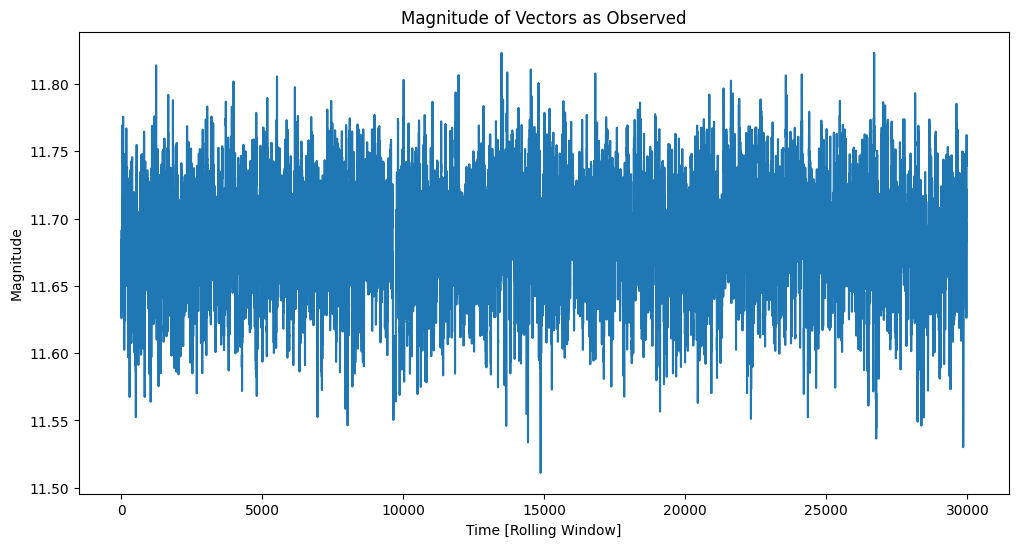

In [18]:
plt.figure(figsize=(12,6))
plt.plot(magnitudes)  # plot the magnitudes as line plot
plt.title('Magnitude of Vectors as Observed')
plt.xlabel('Time [Rolling Window]')
plt.ylabel('Magnitude')
plt.show()

In [38]:
# generate trading signals based on magnitude changes
def generate_signals(magnitudes, thresh=0.01):
    signals = []

    for i in range(1, len(magnitudes)):
        # calculate the change in magnitude
        diff = magnitudes[i] - magnitudes[i-1]
        # generate buy/sell/hold signals based on the threshold
        if diff > thresh:
            signals.append('buy')
        elif diff < -thresh:
            signals.append('sell')
        else:
            signals.append('hold')
    return signals

In [20]:
signals = generate_signals(magnitudes, thresh=0.01)

In [23]:
# add the signals to the OHLC DataFrame to use them alongside price data
ohlc_df = ohlc_df.iloc[:len(signals)].copy()
ohlc_df.loc[:, 'signal'] = signals

In [24]:
ohlc_df.head()

,date,open,high,low,close,volume,signal
1,2015-03-20 09:16:00+05:30,424.50,425.00,424.20,425.00,768,hold
2,2015-03-20 09:17:00+05:30,425.00,425.90,425.00,425.15,425,sell
3,2015-03-20 09:18:00+05:30,425.90,425.95,425.85,425.85,659,hold
4,2015-03-20 09:19:00+05:30,426.25,426.40,425.15,425.15,1548,sell
5,2015-03-20 09:20:00+05:30,424.60,425.00,424.00,424.05,2679,buy


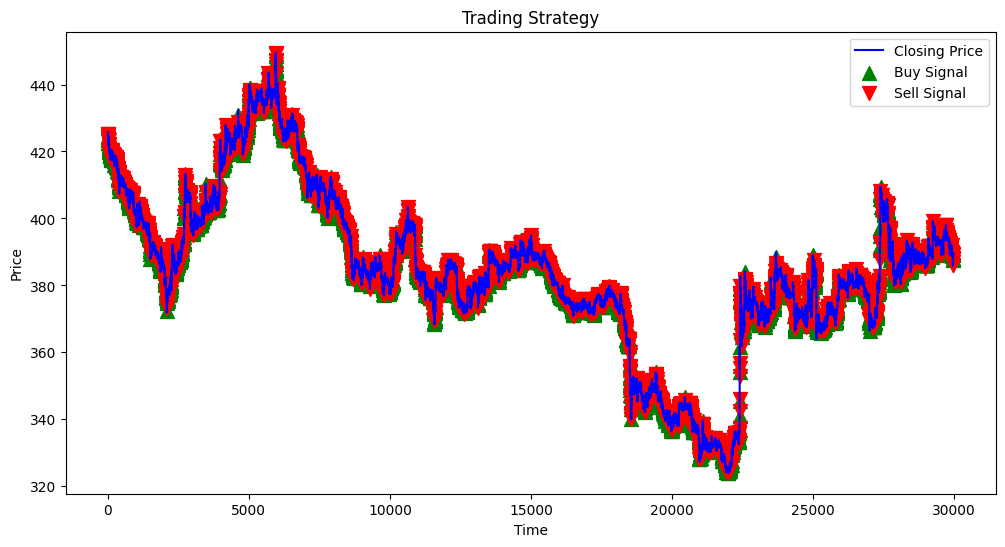

In [28]:
plt.figure(figsize=(12,6))
plt.plot(ohlc_df['close'], label='Closing Price', color='blue')
buy_sign = ohlc_df[ohlc_df['signal'] == 'buy']
sell_sign = ohlc_df[ohlc_df['signal'] == 'sell']

# plot buy signals with green up arrows and plot sell signals with red down arrows
plt.scatter(buy_sign.index, buy_sign['close'], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter(sell_sign.index, sell_sign['close'], color='red', marker='v', label='Sell Signal', s=100)

plt.title('Trading Strategy')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
def backtesting(ohlc_df):
    buyprice = 0
    sellprice = 0
    profit = []
    trade = []

    for index, row in ohlc_df.iterrows():
        signal = row['signal']
        closeprice = row['close']

        # buying stock
        if signal == 'buy' and buyprice == 0:
            buyprice = closeprice

        # selling stock
        elif signal == 'sell' and buyprice != 0:
            sellprice = closeprice
            trade_profit = (sellprice - buyprice) / buyprice  # percentage profit
            profit.append(trade_profit)
            trade.append((buyprice, sellprice, trade_profit * 100))
            buyprice = 0  # Reset buyprice for the next trade

    totalreturn = sum(profit)

    return totalreturn, trade


In [33]:
totalreturn, trade = backtesting(ohlc_df)

In [35]:
print(f"Total Returns : {totalreturn * 100:.2f}%")
print(f"Total Trades Executed: {len(trade)}")

Total Returns : 21.99%
Total Trades Executed: 5683


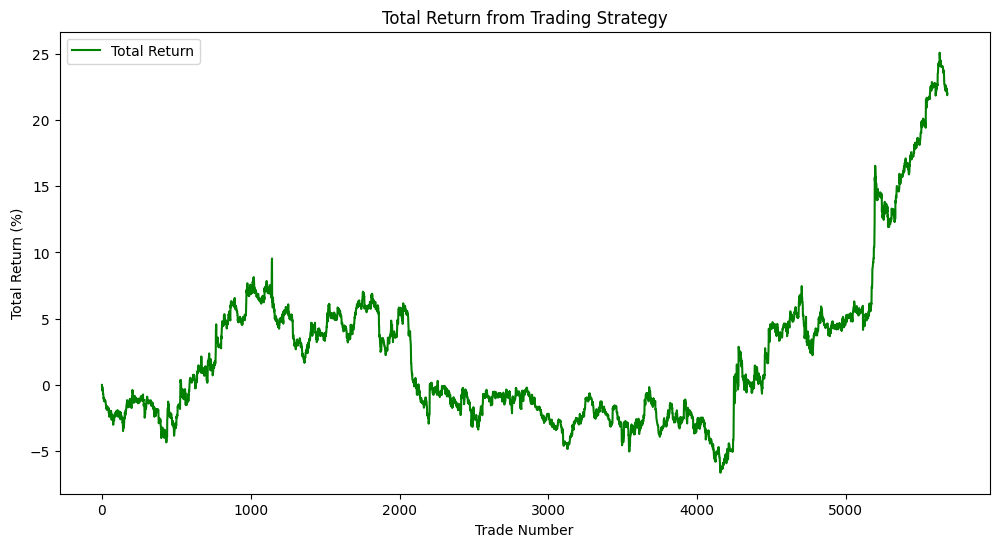

In [36]:
profits = [trade[2] for trade in trade]  # profit percentage from each trade
totalreturn = np.cumsum(profits)

plt.figure(figsize=(12,6))
plt.plot(totalreturn, label='Total Return', color='green')
plt.title('Total Return from Trading Strategy')
plt.xlabel('Trade Number')
plt.ylabel('Total Return (%)')
plt.legend()
plt.show()

In [39]:
# trying to optimize the trade strategy using grid search
import numpy as np

def grid_search(ohlc_df, thresh_range):
    bestreturn = -np.inf
    bestthreshold = None
    result = []

    for thresh in thresh_range:
        signals = generate_signals(magnitudes, thresh)

        ohlc_dftemp = ohlc_df.iloc[:len(signals)].copy()
        ohlc_dftemp['signal'] = signals

        totalreturn, trade = backtesting(ohlc_dftemp)

        result.append((thresh, totalreturn * 100, len(trade)))

        # update the threshold if current return is more
        if totalreturn > bestreturn:
            bestreturn = totalreturn
            bestthreshold = thresh

    return bestthreshold, bestreturn * 100, result

In [42]:
thresh_range = np.arange(0.01, 0.5, 0.01)

bestthreshold, bestreturn, results = grid_search(ohlc_df, thresh_range)

In [43]:
print(f"Best Threshold: {bestthreshold}")
print(f"Best Return: {bestreturn:.2f}%")

# results for each threshold tested
for threshold, totalreturn, num_trades in results:
    print(f"Threshold: {threshold:.2f}, Total Return: {totalreturn:.2f}%, Trades: {num_trades}")

Best Threshold: 0.01
Best Return: 21.99%
Threshold: 0.01, Total Return: 21.99%, Trades: 5683
Threshold: 0.02, Total Return: -3.28%, Trades: 2913
Threshold: 0.03, Total Return: 0.32%, Trades: 1206
Threshold: 0.04, Total Return: 3.17%, Trades: 438
Threshold: 0.05, Total Return: 4.35%, Trades: 144
Threshold: 0.06, Total Return: -1.75%, Trades: 49
Threshold: 0.07, Total Return: -5.05%, Trades: 18
Threshold: 0.08, Total Return: -5.03%, Trades: 8
Threshold: 0.09, Total Return: -3.60%, Trades: 2
Threshold: 0.10, Total Return: -0.40%, Trades: 1
Threshold: 0.11, Total Return: -0.40%, Trades: 1
Threshold: 0.12, Total Return: 0.00%, Trades: 0
Threshold: 0.13, Total Return: 0.00%, Trades: 0
Threshold: 0.14, Total Return: 0.00%, Trades: 0
Threshold: 0.15, Total Return: 0.00%, Trades: 0
Threshold: 0.16, Total Return: 0.00%, Trades: 0
Threshold: 0.17, Total Return: 0.00%, Trades: 0
Threshold: 0.18, Total Return: 0.00%, Trades: 0
Threshold: 0.19, Total Return: 0.00%, Trades: 0
Threshold: 0.20, Total R

# Documentation of the trading strategy
The object of this project is to design and backtest a trading strategy using pre-calculated vector representations of the movement in stock prices. These vectors will be created using a rolling window, which encodes the price trend over time. The signals for buying or selling would be obtained based on changes in the magnitudes of such vectors. The goal was to achieve the highest profitability while maintaining a balanced number of trades. The dataset included minute-by-minute stock price information from Reliance.csv, along with pre-calculated vector data from Reliance_embeddings.kv, which represented stock price movements. To analyze trends, we focused on the close prices in the OHLC data, while the intensity of price movements was measured using the magnitudes (Euclidean norm) of the vectors.

The trading strategy followed straightforward rules: a "buy" signal was triggered when the vector magnitude increased beyond a certain threshold, a "sell" signal was triggered when it dropped, and a "hold" signal was generated if the change was within the threshold range. The optimal thresholds were determined through a grid search. The strategy was then backtested by simulating trades based on the generated signals, calculating the profit from each trade, and evaluating the overall return and number of trades executed.. The grid search for the optimal thresholds ranged from 0.01 to 0.5.

The main result was that, with a threshold of 0.01, the return was the highest at 21.99%, but the number of trades executed is rather large, at 5683. In contrast, a threshold of 0.05 resulted in a lower return of 4.35% but with only 144 trades, making this strategy at least more viable to prevent overtrading. While the highest return was provided by the threshold of 0.01, it required more substantial numbers of trades and can thus be expected to result in higher transaction costs in a real-world environment. The 0.05 threshold provided more balance, as it reduced the number of trades, but it still achieved a positive return. This evaluation was essential for the strategy, as its best return against the threshold of 0.01 yielded a total return of 21.99% with 5683 trades, while the balanced approach with the threshold of 0.05 yielded a total return of 4.35% with 144 trades.

The bottom line for this is: in case the target is profit maximization, then 0.01 presents the optimal threshold; for an investor trying to minimize the number of trades with a positive return, the threshold should be 0.05. The huge amount of trades at the 0.01 threshold may cause a problem in real life concerning transaction costs, too, and adding those costs to the simulation may allow for even more sophisticated fine-tuning of the real performance of this strategy.
